In [47]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from scipy.stats import zscore

In [48]:
np.random.seed(42)
# set_backend("cupy")
plt.style.use("default")
sns.set_theme(style="whitegrid")

In [49]:
n_samples_train = 1000
n_samples_test = 100
n_targets = 10000
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
noise_scalar = 0.1

In [50]:
feature_spaces = []
# Generate a random matrix of shape (samples, total rank)
M = np.random.randn(n_samples_train + n_samples_test, sum(d_list))
M = zscore(M)
M

array([[ 0.47184223, -0.12471972,  0.67046674, ...,  0.29841288,
         0.85108902,  0.6857001 ],
       [-0.8779542 , -0.54591604,  0.77395921, ..., -0.99906232,
        -0.42079477,  0.42996468],
       [ 0.73684571, -0.90728224,  0.90104514, ...,  0.13640207,
         1.2493477 , -0.78039671],
       ...,
       [ 1.86417759,  1.13467061, -0.05470728, ..., -0.16307591,
         0.07761028, -0.87354415],
       [ 0.01080282,  0.25354499, -0.05047578, ..., -0.22748839,
        -1.85091248, -1.35096737],
       [ 0.37236962, -0.14983556, -1.36164894, ...,  1.41518184,
        -1.04903332,  0.80812089]], shape=(1100, 300))

<Axes: ylabel='Count'>

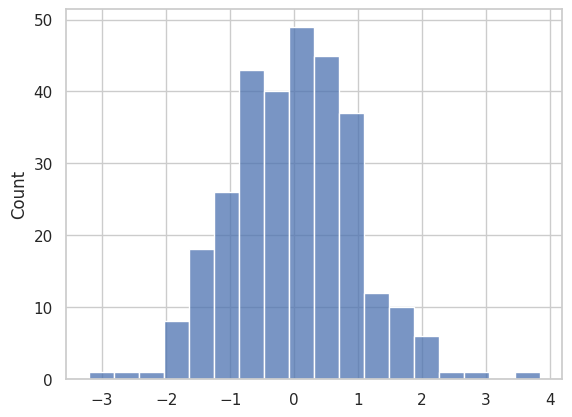

In [51]:
sns.histplot(M[0])

In [52]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)
S

(1100, 300) (300,) (300, 300)


array([49.52930877, 49.33874483, 49.04435523, 48.85777223, 48.59780425,
       48.30515054, 48.19762784, 47.74391064, 47.60567271, 47.38248951,
       47.31040164, 47.11333295, 47.05581164, 46.68165859, 46.64153538,
       46.38825538, 46.26812595, 46.17372817, 46.04514253, 45.97483656,
       45.87268864, 45.52702211, 45.46839537, 45.41403153, 45.20645979,
       45.08751567, 44.85957684, 44.80951133, 44.58420962, 44.43933553,
       44.23903519, 44.01973682, 43.98154209, 43.8047093 , 43.72351628,
       43.6650697 , 43.41469849, 43.3676072 , 43.20071775, 43.06050945,
       42.96427738, 42.81398941, 42.70658611, 42.5952928 , 42.49772557,
       42.30831257, 42.1582332 , 42.06899774, 41.85127067, 41.82007078,
       41.6468681 , 41.54589739, 41.45860085, 41.36700383, 41.27945445,
       41.17303134, 41.06842525, 40.83426998, 40.80704864, 40.68091463,
       40.64214108, 40.37243718, 40.35832869, 40.19889136, 40.10231246,
       40.00669827, 39.76371036, 39.70237691, 39.63288849, 39.46

Text(17.31944444444445, 0.5, 'value')

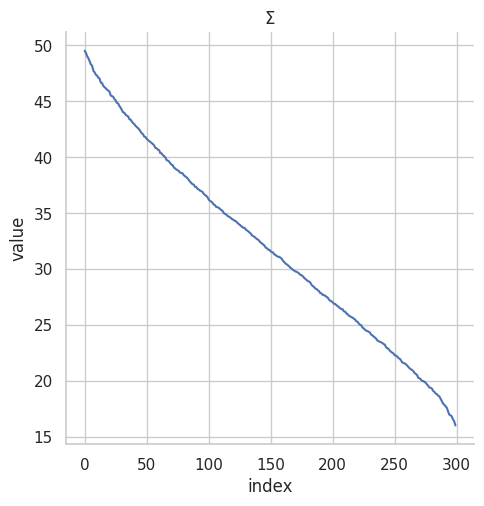

In [53]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$")
plt.xlabel("index")
plt.ylabel("value")

Shuffle U, S and V indices to remove singular value order

In [54]:
index_shuffle = list(range(U.shape[1]))
random.shuffle(index_shuffle)
U = U[:, index_shuffle]
S = S[index_shuffle]
Vt = Vt[index_shuffle, :]

Text(17.31944444444445, 0.5, 'value')

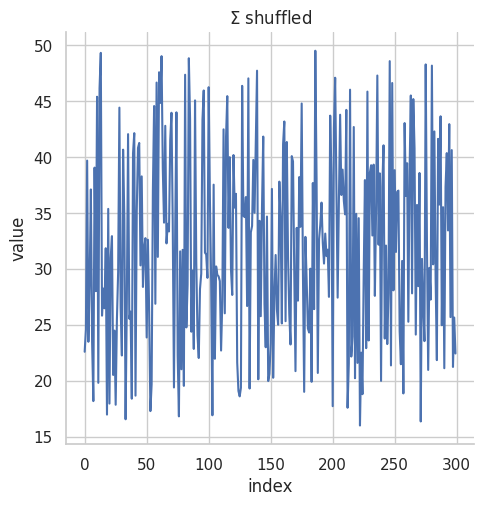

In [55]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$ shuffled")
plt.xlabel("index")
plt.ylabel("value")

Split up S to create three orthogonal matrices to be used as feature spaces

In [56]:
start = 0
for rank in d_list:
    _S = np.zeros(len(S))
    _S[start:start + rank] = S[start:start + rank]

    diag_S = np.diag(_S)

    space = U @ diag_S @ Vt
    feature_spaces.append(space)
    start += rank
feature_spaces

[array([[ 1.55208507, -0.7469203 ,  0.67827869, ...,  0.43368932,
          0.63249477,  0.8900672 ],
        [-0.72421504, -1.10866621,  0.33195033, ..., -0.28321912,
         -0.02670859,  0.42992437],
        [ 0.18309662,  0.00771647,  0.09562907, ..., -0.13657646,
          0.05016038, -0.53243075],
        ...,
        [ 1.0439104 ,  0.8020621 , -0.04161788, ..., -0.44695588,
          0.21108819, -0.26278268],
        [ 0.40472749, -0.13489429,  0.1718446 , ..., -0.26555685,
         -0.70726251,  0.1825389 ],
        [ 0.0272182 , -0.32860802,  0.22852746, ..., -0.12981863,
         -0.63228089,  0.8028858 ]], shape=(1100, 300)),
 array([[ 0.24083814,  0.44316491, -0.13648617, ...,  0.33858978,
          0.67362075, -0.00464346],
        [-0.53015566,  0.43403516,  0.67292931, ..., -0.18188094,
         -0.18847911, -0.11578515],
        [ 0.28723493, -0.88610826,  0.0320591 , ..., -0.36411089,
          0.56789803, -0.56590996],
        ...,
        [ 0.52275871, -0.27537117, 

Text(0.5, 0, 'value')

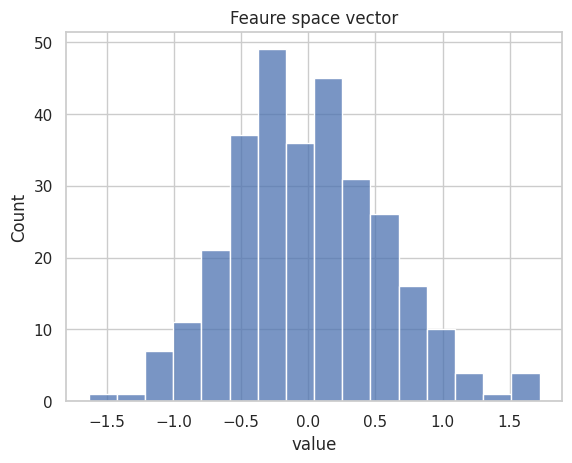

In [69]:
sns.histplot(feature_spaces[0][0])
plt.title("Feaure space vector")
plt.xlabel("value")

make sure that all feature spaces are orthogonal to each other (histograms should be nearly 0)

In [98]:
import pandas as pd

matmuls_df = pd.DataFrame()

for i in range(len(feature_spaces)):
    for j in range(i + 1, len(feature_spaces)):
        first_transposed = feature_spaces[i].T @ feature_spaces[j] # (n_features, n_samples) @ (n_samples, n_features) = (n_
        second_transposed = feature_spaces[i] @ feature_spaces[j].T
        matmuls_df = pd.concat([
            matmuls_df,
            pd.DataFrame(
                {'Features': [f"Space({i}) x Space({j})"], 'Type': ['First Transposed'], 'Values (avg across samples)': [first_transposed.mean(axis=0)]}),
            pd.DataFrame(
                {'Type': ['Second Transposed'], 'Values (avg across samples)': [second_transposed.mean(axis=0)], 'Features': [f"Space({i}) x Space({j})"]}),
        ], ignore_index=True)
matmuls_df

,Features,Type,Values (avg across samples)
0,Space(0) x Space(1),First Transposed,"[-1.9434049277252303e-15, 4.889549413504095e-16, -6.7151723996220865e-16, 1.4680849128959986e-15, 1.545106635229369e-15, 2.35133671792435e-15, -1.549894472023065e-15, 1.2866328373088247e-15, -2.78937752525484e-15, -6.207433294232641e-16, 1.1928768158438648e-15, 1.8824857760576148e-16, 3.025184269755954e-15, -5.596449229964643e-16, -2.7586729197300505e-16, 4.346014289187868e-15, 4.3945576344572856e-15, -2.313091847690648e-15, -1.8699885390160986e-16, 1.60810600946526e-15, 1.7216277593360788e-15, 2.872239483290665e-16, -2.4971691381381333e-15, 2.895785463271257e-15, -2.124989998778896e-15, -3.0244571314989402e-15, -1.980979038214888e-15, 5.811612765101633e-16, -1.1741707143612483e-15, -1.9714149294506693e-15, 3.728666680968828e-15, -9.094345646924277e-16, 2.077967427756751e-15, 1.9320135768996494e-15, 1.6896380128361699e-15, 2.1997594717992897e-16, -2.759786033960469e-15, 9.86074647861083e-17, 4.494668526255907e-15, -2.4464140204368454e-15, -1.6075537891587408e-15, -1.3688009059542593e-15, 1.3719985795616433e-15, 1.1214293382799668e-15, 1.9702989240144574e-15, -1.7380021033464032e-15, -2.398058603543992e-15, -4.952190278221617e-15, 8.842145765575182e-16, -1.439262482342644e-15, -9.513859607531334e-16, 6.733040051424647e-16, -2.3978215246689415e-16, 2.309275456043499e-15, -1.539925594447785e-15, 2.6167725393951476e-16, 1.9878080662986502e-15, 4.366738452314205e-15, -5.178959113412892e-16, 9.853663024417258e-16, 1.0564350320467024e-15, 3.737739284748187e-15, -3.623477386194285e-15, -1.652668164357311e-15, -4.509078295929688e-15, 7.616014300696843e-16, 1.0730305533002137e-15, 1.7357411804160469e-15, 4.922971752474581e-16, -2.2176488076453006e-15, -6.30294427761413e-16, -4.251922887850886e-16, 1.4053399647699176e-15, 2.1863471681241955e-15, 1.1224123482496869e-15, 1.9964354243858412e-15, 4.8695827462956015e-15, -3.0916299612974523e-15, 1.7270675630361628e-15, 3.578029076726589e-15, -1.5484604339495907e-15, -7.023172552781769e-16, -2.9921233315096293e-15, -1.5408074122147398e-15, 1.80779002878495e-15, 9.853728076547607e-16, 9.726016288643299e-17, -2.058735126819755e-15, -1.927358735572445e-15, 1.3720997717644087e-15, 1.5630855984549719e-15, -3.238297939985498e-15, 9.51969984323379e-16, -2.287545153301096e-15, 5.063310881681104e-16, 2.7725835950037636e-15, -2.946283263656942e-16, 1.3537782006523002e-15, -1.5015274903070383e-15, 1.5412945803909098e-15, ...]"
1,Space(0) x Space(1),Second Transposed,"[2.475923506621443e-19, 9.141499899228462e-17, 1.7249065181241202e-17, -6.741332555313597e-17, -6.261918067407279e-17, -4.4994882977317745e-17, 3.921578970646842e-17, -5.292700463505556e-17, -8.870823898675763e-17, -1.62660880661323e-17, -1.1067328792680918e-16, 1.4825971889569962e-17, 6.818744590429062e-18, 1.290446994842406e-16, -9.166199995994358e-17, -4.464547418627583e-18, -6.13126184923939e-18, 1.6652300592738408e-16, -1.0087811268140583e-17, 1.7771276085810537e-16, 9.46145781671232e-17, -2.019375828171183e-17, -8.966470243055756e-17, 3.8224631793148945e-17, 1.6061489259800898e-16, -1.0453522517303329e-16, 6.800155451362629e-17, -1.935289050226562e-16, -4.745966877071275e-17, 8.94234181652626e-17, -7.522529789739562e-17, -7.344484080250669e-17, -1.0099155965418136e-16, -1.4904625828992092e-16, 1.7529144171544366e-16, 3.5338633455743325e-17, 4.041511443690511e-18, -2.9816496099773063e-17, 7.360473598198985e-17, -2.521499423399379e-17, -4.399889543613902e-19, -5.706254597625072e-17, -2.2500940504760985e-17, 3.225516247719455e-17, 3.224515824805753e-17, -1.3591558434278284e-17, -1.2615855330108418e-16, -9.134896122359686e-17, 9.110176312827017e-17, -2.4141436955565415e-17, -4.790202325708683e-17, 2.0453966803108353e-17, 1.6267172268304785e-16, 9.838168789734102e-17, -6.429910265842215e-17, -1.972774847521079e-17, 1.7441067529605e-17, 1.0950997595716993e-16, 7.855931814162241e-17, -7.631758230425783e-17, 3.933347492410003e-17, -9.125355143241814e-17, 4.01499

Text(0.5, 1.02, '')

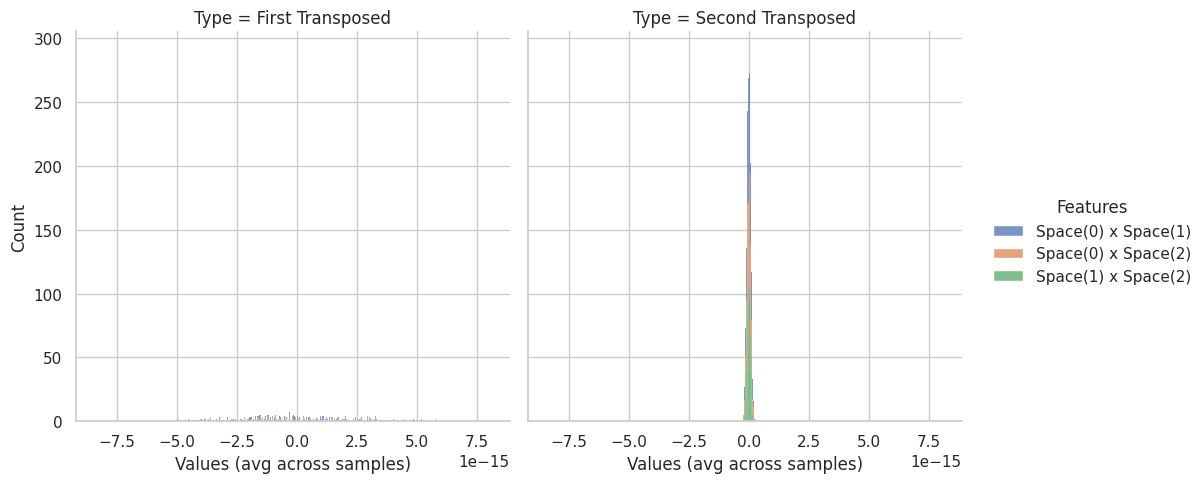

In [99]:
sns.displot(data=matmuls_df.explode("Values (avg across samples)"), x="Values (avg across samples)",  multiple="stack", col="Type", hue="Features")
plt.suptitle('', y=1.02)

split feature spaces into train and test samples

In [60]:
feature_spaces_train = [feature_space[:n_samples_train] for feature_space in feature_spaces]
feature_spaces_test = [feature_space[n_samples_train:] for feature_space in feature_spaces]

add the first feature with all other feature spaces
[0 + 1, 0 + 2, 0 + 3, ...]

In [61]:
Xs_train = [1 / 2 * (feature_spaces_train[0] + feature_space) for feature_space in feature_spaces_train[1:]]
Xs_test = [1 / 2 * (feature_spaces_test[0] + feature_space) for feature_space in feature_spaces_test[1:]]

Xs_train = [zscore(x) for x in Xs_train]
Xs_test = [zscore(x) for x in Xs_test]

generate weights

In [62]:
betas = [np.random.randn(sum(d_list), n_targets) for _ in d_list]
betas = [zscore(beta) for beta in betas]
betas

[array([[-0.38460629, -0.16970626, -0.43662699, ...,  0.76389093,
         -0.54724117,  2.90284843],
        [-0.09814713, -0.20278397,  0.5237513 , ...,  0.93230933,
          1.28752009,  0.04879971],
        [ 0.47496226, -0.72079155, -0.59932401, ..., -0.25245321,
         -0.37423414, -0.61704289],
        ...,
        [ 1.39478625,  0.53454755,  0.11210573, ...,  0.33811356,
          0.07469666,  0.29992802],
        [-0.61751344,  0.74781886,  0.45996191, ...,  2.27891114,
          0.04883194,  0.07789179],
        [-0.98042467, -0.2961056 , -0.67027179, ..., -0.92429298,
          0.47219762,  0.44713567]], shape=(300, 10000)),
 array([[-1.40169847,  2.67279918,  2.03973585, ..., -0.03094923,
         -0.58427223, -0.49388827],
        [-0.66347222,  1.0093984 ,  0.65018904, ..., -0.88144256,
         -1.113028  ,  0.78376731],
        [-1.5680825 , -0.47965058,  1.07959107, ..., -1.27468081,
         -0.45572124,  0.11798338],
        ...,
        [ 1.07480511, -1.37367909,

create targets

In [63]:
Y_train = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_train, betas)])
Y_test = sum(
    [alpha * zscore(feature_space @ beta) for alpha, feature_space, beta in
     zip(scalars, feature_spaces_test, betas)])
Y_train = zscore(Y_train)
Y_test = zscore(Y_test)

add noise

In [64]:
noise_train = zscore(np.random.randn(n_samples_train, n_targets))
noise_test = zscore(np.random.randn(n_samples_test, n_targets))
Y_train += noise_train * noise_scalar
Y_test += noise_test * noise_scalar
noise_train * noise_scalar

array([[-0.00063417,  0.01154315, -0.03187855, ...,  0.08611207,
        -0.12916102,  0.08738936],
       [ 0.03938965,  0.00242483, -0.02673386, ...,  0.11971031,
        -0.16322497,  0.09760446],
       [ 0.08482156, -0.09030948,  0.05056161, ..., -0.02505592,
         0.01699247, -0.00441444],
       ...,
       [ 0.15958723,  0.01918551,  0.11944391, ..., -0.06331546,
        -0.02140708,  0.12214556],
       [-0.03527165,  0.07056346, -0.27609341, ...,  0.1827738 ,
         0.00448845, -0.07623852],
       [ 0.19636524,  0.04896127,  0.02460273, ...,  0.02527466,
         0.09929174, -0.21056221]], shape=(1000, 10000))

train simple linear models to confirm feature spaces predict the target

In [65]:
scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(feature_spaces_train))]
for i, model in enumerate(linear_models):
    model.fit(feature_spaces_train[i], Y_train)
    score = model.score(feature_spaces_test[i], Y_test)
    scores = pd.concat([
        scores,
        pd.DataFrame({'model': [i], 'Type': ['Score'], 'Values': [score.mean()]})], ignore_index=True
    )

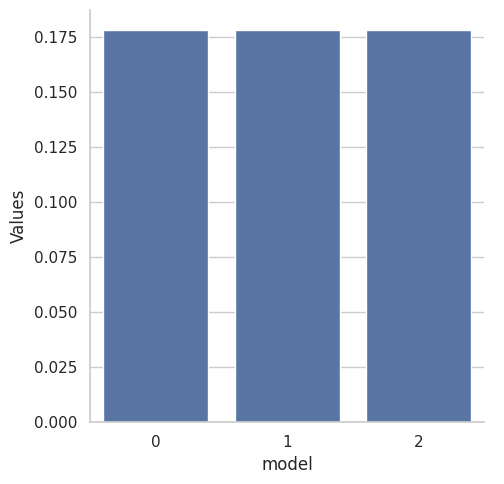

In [66]:
sns.catplot(scores, x="model", y="Values", kind="bar")

now train on researcher side feature spaces

In [67]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(Xs_train))]
for i, model in enumerate(linear_models):
    model.fit(Xs_train[i], Y_train)
    score = model.score(Xs_test[i], Y_test)
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'model': [i], 'Type': ['Score'], 'Values': [score.mean()]})], ignore_index=True
    )

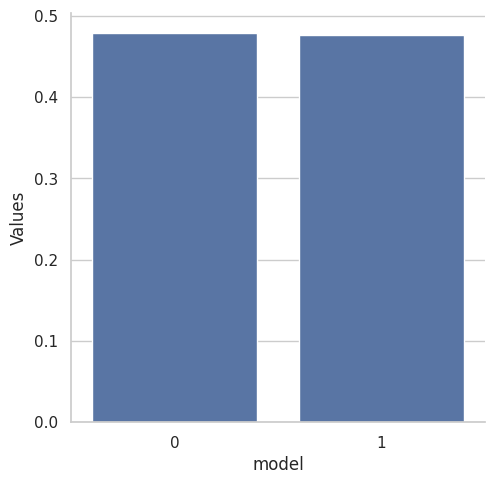

In [68]:
sns.catplot(researcher_scores, x="model", y="Values", kind="bar")